In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
! pip install PyWavelets==0.5.2
! pip install seaborn==0.8.1
! pip install opencv-python==3.4.3.18


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 20.2 MB/s 
  Attempting uninstall: PyWavelets
    Found existing installation: PyWavelets 1.3.0
    Uninstalling PyWavelets-1.3.0:
      Successfully uninstalled PyWavelets-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.18.3 requires PyWavelets>=1.1.1, but you have pywavelets 0.5.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 178 kB 29.4 MB/s 
  Created wheel for seaborn: filename=seaborn-0.8.1-py3-none-any.whl size=184850 sha256=f0c5e7151fea53da11e745eb3fba5e2ed1232f48e40db19e3ea9

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pwd


/content


## (1) Preprocessing: Detect face and eyes

When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>


Now how do you detect face and eyes?
We will use haar cascade from opencv for this. 
Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

In [ ]:
img = cv2.imread("drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/test image/The Board of Control for Cricket in India.png")
img.shape

(700, 520, 3)

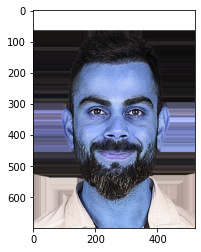

In [ ]:
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(700, 520)

In [ ]:
gray


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [227, 238, 241, ..., 186, 200, 221],
       [227, 232, 240, ..., 204, 195, 202],
       [226, 225, 238, ..., 239, 216, 193]], dtype=uint8)

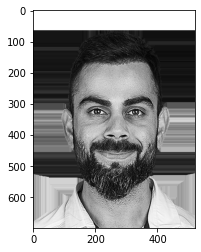

In [ ]:
plt.imshow(gray, cmap='gray')


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 86, 178, 362, 362]], dtype=int32)

In [ ]:
(x,y,w,h) = faces[0]
x,y,w,h

(86, 178, 362, 362)

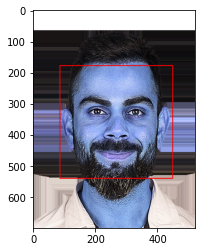

In [ ]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

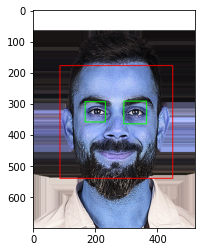

In [ ]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

## (2) Preprocessing: Crop the facial region of the image

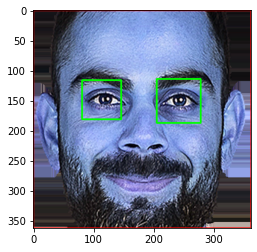

In [ ]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [ ]:
cropped_img = np.array(roi_color)
cropped_img.shape

(362, 362, 3)

# Preprocessing: Use wavelet transform as a feature for traning our model


In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc


# Wavelet transform


In [ ]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

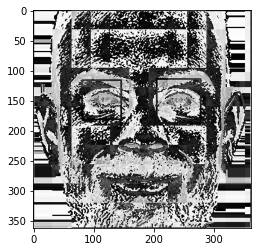

In [ ]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

# Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                            return roi_color

# def get_cropped_image_if_2_eyes(image_path):
#     img = cv2.imread(image_path)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#     for (x,y,w,h) in faces:
#         roi_gray = gray[y:y+h, x:x+w]
#         roi_color = img[y:y+h, x:x+w]
#         eyes = eye_cascade.detectMultiScale(roi_gray)
#         if len(eyes) >= 2:
#             return roi_color

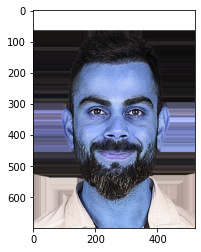

In [ ]:
original_image = cv2.imread("drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/test image/The Board of Control for Cricket in India.png")
plt.imshow(original_image)

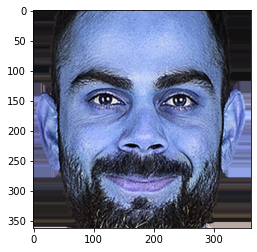

In [ ]:
cropped_image = get_cropped_image_if_2_eyes("drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/test image/The Board of Control for Cricket in India.png")
plt.imshow(cropped_image)

In below image face is not very clear and it doesn't have two eyes clearly visible



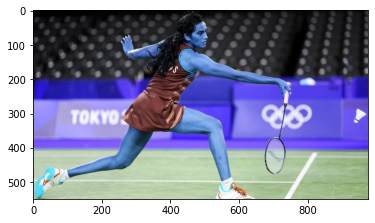

In [ ]:
org_image_obstructed = cv2.imread("drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/test image/PV Sindhu at Tokyo Olympics_ India star.jpg")
plt.imshow(org_image_obstructed)

In [ ]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes("drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/test image/PV Sindhu at Tokyo Olympics_ India star")
cropped_image_no_2_eyes

Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training




In [ ]:
path_to_data = "drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET"
path_to_cr_data ="drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/"

In [ ]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/NARENDRA MODI - Google Search',
 'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/pv sindhu - Google Search',
 'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/virat kohli - Google Search',
 'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/VIJAY DEVARAKONDA - Google Search',
 'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/jhonny dep - Google Search']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code



In [ ]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
?os.mkdir(path_to_cr_data)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search
Generating cropped images in folder:  drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/pv sindhu - Google Search
Generating cropped images in folder:  drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/virat kohli - Google Search
Generating cropped images in folder:  drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/VIJAY DEVARAKONDA - Google Search
Generating cropped images in folder:  drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/jhonny dep - Google Search


Now you should have cropped folder under datasets folder that contains cropped images

Manually examine cropped folder and delete any unwanted images

In [ ]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'NARENDRA MODI - Google Search': ['drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search1.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search2.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search3.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search4.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search6.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/DATA SET/cropped/NARENDRA MODI - Google Search/NARENDRA MODI - Google Search8.png',
  'drive/My Drive/CDC_CLASSIFICATION/CODE/PEOPLE CLASSIFIER/model/D

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'NARENDRA MODI - Google Search': 0,
 'VIJAY DEVARAKONDA - Google Search': 3,
 'jhonny dep - Google Search': 4,
 'pv sindhu - Google Search': 1,
 'virat kohli - Google Search': 2}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier.

 Let's prepare X and y now

In [ ]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [ ]:
len(X[0])


4096

In [ ]:
32*32*3 + 32*32

4096

In [ ]:
X[0]


array([[ 32],
       [ 97],
       [221],
       ...,
       [  9],
       [103],
       [244]], dtype=uint8)

In [ ]:
y[0]

0

In [ ]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(207, 4096)

# Data cleaning process is done. Now we are ready to train our model


We will use SVM with rbf kernel tuned with heuristic finetuning

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6346153846153846

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.50      0.62      0.55        13
           2       0.80      0.57      0.67         7
           3       0.64      0.47      0.54        15
           4       0.55      0.75      0.63         8

    accuracy                           0.63        52
   macro avg       0.67      0.66      0.66        52
weighted avg       0.65      0.63      0.63        52



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.774194,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.651613,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.806452,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)


0.6346153846153846

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)


0.4423076923076923

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)


0.6923076923076923

In [ ]:
best_clf = best_estimators['svm']


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[8, 0, 0, 0, 1],
       [0, 8, 0, 2, 3],
       [0, 1, 4, 2, 0],
       [1, 5, 1, 7, 1],
       [0, 2, 0, 0, 6]])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(69.0, 0.5, 'Truth')

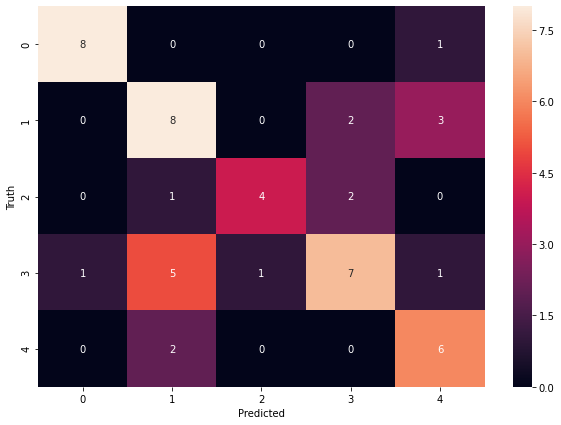

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
class_dict


{'NARENDRA MODI - Google Search': 0,
 'VIJAY DEVARAKONDA - Google Search': 3,
 'jhonny dep - Google Search': 4,
 'pv sindhu - Google Search': 1,
 'virat kohli - Google Search': 2}

Save the trained model


In [ ]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['saved_model.pkl']

Save class dictionary

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))